In [1]:
%matplotlib inline
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.io as io
import matplotlib.pylab as plt
from pathlib import Path

8266217.206972408

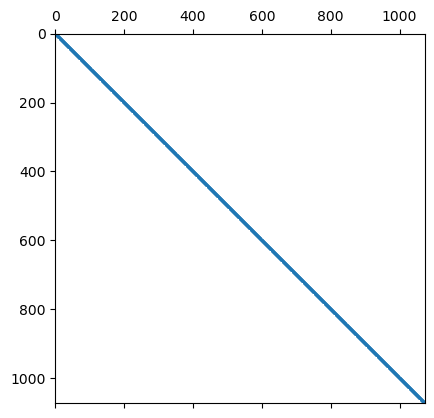

In [2]:
path = "~/Downloads/ch3-3-b2/"
path = "~/Downloads/farm/"
path = "~/Downloads/mesh1em1/"
path = "~/Downloads/pores_1/"
# path = "~/Downloads/bcsstm02/"
path = "~/Downloads/bcsstm08/"
files = list(Path(path).expanduser().glob("*"))

fig, axs = plt.subplots(nrows=1, ncols=len(files))

for i, file in enumerate(files):
    A = io.mmread(file)
    ax = axs[i] if len(files) > 1 else axs
    ax.spy(A, markersize=1)
assert np.all(A.toarray() == A.toarray().T)
np.linalg.cond(A.toarray())

In [3]:
N = A.shape[0]
# b = np.ones((N))
b = np.random.uniform(size=N)
sol = linalg.spsolve(A, b)
np.linalg.norm(A @ sol - b)

/usr/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


7.273664712645119e-16

In [4]:
def cg(A, b):
    # x = np.random.rand(*b.shape)
    x = np.zeros(b.shape)
    r = b - A @ x
    rr = r.T.dot(r)
    p = r
    for k in range(1000):
        Ap = A @ p # A.dot(p)
        a = rr / p.T.dot(Ap)
        x = x + a * p
        r = r - a * Ap
        rr1 = r.T.dot(r)
        b = rr1 / rr
        rr = rr1
        p = r + b * p
    return x

cg_sol = cg(A, b)

print(A @ cg_sol - b)


[ 1.33226763e-15  0.00000000e+00  6.66133815e-16 ... -1.11022302e-16
  0.00000000e+00 -3.33066907e-16]


In [5]:
np.linalg.cond(A.toarray())

8266217.206972408

In [6]:
def check(x, b, numtests=5):
    for _ in range(numtests):
        xbad = x + np.random.normal(size=x.shape)
        d = np.linalg.norm(x-b)
        dbad = np.linalg.norm(xbad-b)
        assert dbad > d

def krylov(M, A, r):
    M[0] = r.copy()
    for i in range(1, len(M)):
        M[i] = A @ M[i-1]
    return M, M @ r


In [19]:
numsteps = 400
Rs = np.zeros([numsteps, N])
alphas = np.zeros(numsteps)
betas = np.zeros(numsteps)
Ps = np.zeros([numsteps, N])
Xs = np.zeros([numsteps, N])
rrs = np.zeros(numsteps)
rArs = np.zeros(numsteps)
def cg_algo23(A, b, numsteps):
    x = np.zeros(b.shape)
    r = b - A @ x
    p = r
    Ar = A @ r
    rr = r @ r
    rAr = r @ Ar
    alpha = rr / rAr
    beta = 0.0
    Ap = np.ones(*r.shape)
    print("      r         alpha          beta             p           x          rr         rAr")
    for i in range(numsteps):
        p = r + beta * p
        Ap = Ar + beta * Ap
        rcheck = np.all(np.isclose(b - A @ x, r))
        x += alpha * p
        print(f"{np.linalg.norm(r):7.5}, "
              f"{alpha:12.5}, "
              f"{beta:12.5}, "
              f"{np.linalg.norm(p):12.5}"
              f"{np.linalg.norm(x):12.5}"
              f"{np.linalg.norm(rr):12.5}"
              f"{np.linalg.norm(rAr):12.5}"
              f" {rcheck}"
             )
        Rs[i], alphas[i], betas[i], Ps[i], Xs[i], rrs[i], rArs[i] = r, alpha, beta, p, x, rr, rAr
        r = r - alpha * Ap
        Ar = A @ r
        rAr = r @ Ar
        beta = r @ r / rr
        rr = r @ r
        alpha = rr / (rAr - beta/alpha * rr)
    return x

x_sol_23 = cg_algo23(A, b, numsteps)
r = A @ x_sol_23 - b
# print(np.linalg.norm(r))
# assert np.all(np.isclose(r, 0)), "Not a solution."

      r         alpha          beta             p           x          rr         rAr
 19.126,   0.00011491,          0.0,       19.126   0.0021978       365.8  3.1833e+06 True
 209.81,   5.9548e-06,       120.34,       2311.2    0.015953  4.4021e+04  5.3492e+10 True
 297.78,   1.6629e-06,       2.0143,       4664.9    0.023699  8.8671e+04  8.3316e+10 True
 141.21,     1.38e-06,      0.22487,       1058.5    0.025146   1.994e+04  1.7146e+10 True
 89.624,   4.6245e-06,      0.40284,       435.71    0.027105      8032.5  4.0818e+09 True
 93.675,   1.4079e-06,       1.0924,       485.12    0.027759      8775.1  8.3057e+09 True
 34.716,   1.0694e-05,      0.13735,       75.131    0.028444      1205.2  2.3028e+08 True
 16.298,   5.2062e-05,      0.22039,       23.233    0.029199      265.62  1.0576e+07 True
 31.582,     0.027349,       3.7551,       92.783      2.5551      997.41  7.1977e+07 True
 49.454,     0.020639,        2.452,       232.82      7.3221      2445.7  3.3776e+05 True
 33.

In [26]:
s = 1
x = np.zeros(b.shape)
P = np.zeros([s, len(b)])
Q = np.zeros([s, len(b)])
mu = np.zeros(2*s)
beta = np.zeros([s, s])
#alpha = np.zeros(s)
c = np.ones([s, s])

r = b - A @ x
# print(np.linalg.norm(r))
Q, mu = krylov(Q, A, r)

print("              r         alpha          beta             p           x          rr         rAr")
for i in range(numsteps):
    if i > 0:
        c[0, -1] = - r @ Akr / alpha[-1]
        beta[0] = np.linalg.solve(W, -c[0])
        for k in range(1, s):
            Akr = A @ Akr
            c[k, :-1] = c[k, 1:]
            rest = sum([alpha[-2-t] * c[k, -2-t] for t in range(k)])
            # assert np.isclose(r @ Akr, mu[k])
            c[k, -1] = -1 / alpha[-1] * ((r @ Akr) + rest)
            beta[k] = np.linalg.solve(W, -c[k])
    mod = - beta/alpha * mu if i > 0 else 0
    W = np.array([[pj @ (A @ pi) for pi in Q] for pj in Q]) + mod
    alpha = np.linalg.solve(W, mu)
    Q = Q + beta @ P
    x = x + alpha @ Q
#     print(f">> {np.linalg.norm(r - Rs[i]):12.5}ER"
#           f"{np.linalg.norm(alpha - alphas[i]):12.5}ER"
#           f"{np.linalg.norm(beta - betas[i]):12.5}ER"
#           f"{np.linalg.norm(Q - Ps[i]):12.5}ER"
#           f"{np.linalg.norm(x - Xs[i]):12.5}ER"
#           f"{np.linalg.norm(mu - rrs[i]):12.5}ER"
#           f"{np.linalg.norm(W - rArs[i]):12.5}ER"
#          )
    print(f"        {np.linalg.norm(r):7.5}, "
          f"{np.linalg.norm(alpha):12.5}, "
          f"{np.linalg.norm(beta):12.5}, "
          f"{np.linalg.norm(Q):12.5}, "
          f"{np.linalg.norm(x):12.5}, "
          f"{np.linalg.norm(mu):12.5}, "
          f"{np.linalg.norm(W):12.5},"
         )
    r = b - A @ x
    Akr = r.copy()
    # check(x, b)
    # print(f"{np.linalg.norm(r)=}")
    P, mu = krylov(P, A, r)
    P, Q = Q, P

#s_cg_sol = s_cg(A, b)
s_cg_sol = x
# print(np.linalg.norm(s_cg_sol @ A - b))

              r         alpha          beta             p           x          rr         rAr
         19.126,   0.00011491,          0.0,       19.126,    0.0021978,        365.8,   3.1833e+06,
         209.81,   5.9548e-06,       120.34,       2311.2,     0.015953,   4.4021e+04,   7.3924e+09,
         297.78,   1.6629e-06,       2.0143,       4664.9,     0.023699,   8.8671e+04,   5.3322e+10,
         141.21,     1.38e-06,      0.22487,       1058.5,     0.025146,    1.994e+04,   1.4449e+10,
         89.624,   4.6245e-06,      0.40284,       435.71,     0.027105,       8032.5,   1.7369e+09,
         93.675,   1.4079e-06,       1.0924,       485.12,     0.027759,       8775.1,   6.2328e+09,
         34.716,   1.0694e-05,      0.13735,       75.131,     0.028444,       1205.2,    1.127e+08,
         16.298,   5.2062e-05,      0.22039,       23.233,     0.029199,       265.62,    5.102e+06,
         31.582,     0.027349,       3.7551,       92.783,       2.5551,       997.41,   3.6469e+0